In [19]:
import sys
sys.path
sys.path.append('/Users/mulingsi/Desktop/MSE346/RL-book/')

In [20]:
from dataclasses import dataclass
from typing import Optional, Mapping, Dict, Sequence, Tuple
import numpy as np
import itertools
from rl.distribution import Categorical, Constant, Choose
from rl.markov_process import MarkovProcess, Transition, FiniteMarkovProcess
from scipy.stats import poisson
from rl.gen_utils.common_funcs import get_logistic_func, get_unit_sigmoid_func

import matplotlib.pyplot as plt

Note: Solved for Q1, Q2, Q4 first as they all belong to the Snakes and Ladders problem. Q3 and Q5 follows.

# Q1: Snake and Ladders - setup

![](SL-graph.jpg)

- State Space: $\mathcal{S}$ = {0, 1, ..., 100}, $\mathcal{T} $={100}, 
- Transition Probabilities: There are three kinds of states - regular, snake, and ladder states. The snake states send you to a lower state and the ladder sends you higher state. There's also the bounce back rule that if your roll goes to above 100, you'll be send back for the additional rolls that goes above 100. Details see Q2.

# Q2: Snake and ladder - transition map

In [116]:
@dataclass(frozen=True)
class PositionState:
    position: int


class SnakeLadder(FiniteMarkovProcess[PositionState]):

    def __init__(
        self,
       
        dice_size: int,
        board_size: int,
        snake_ladders: Dict[int, int],):
        self.dice_size = dice_size
        self.board_size =board_size
        self.snake_ladders =snake_ladders
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Transition[PositionState]:
        d: Dict[PositionState, Optional[Categorical[PositionState]]] = {
            PositionState(self.board_size) : None
        }
        for pos in range(self.board_size):
            state = PositionState(pos)
            state_probs_map: Mapping[PositionState, float] = {}
            
            # roll dice 
            for dice_roll in range(1,self.dice_size+1):
                if dice_roll+pos >100:
                    j = 100-(dice_roll+pos-100)
                elif dice_roll+pos in self.snake_ladders.keys():
                    j = self.snake_ladders[dice_roll+pos]
                else:
                    j = dice_roll+pos
                
                state_probs_map[PositionState(j)] = 1/self.dice_size
            d[state] = Categorical(state_probs_map)
        return d
    

In [ ]:
snakes_map = {38:1,31:6, 49:8,65:14,53:17,70:34,76:37,94:42,88:50,82:63,98:54
              
}
ladders_map = {3:39,7:48,12:51,20:41,25:57,28:35,45:74,60:85,67:90, 69:92,77:83

}

snakes_and_ladders_map = {**snakes_map, **ladders_map}

In [118]:
if __name__ == '__main__':

    sl_mp = SnakeLadder(
        board_size=100,
        dice_size=6,
       snake_ladders =snakes_and_ladders_map 
    )

    print("Transition Map")
    print("--------------")
    print(sl_mp)

Transition Map
--------------
PositionState(position=100) is a Terminal State
From State PositionState(position=0):
  To State PositionState(position=1) with Probability 0.167
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
From State PositionState(position=1):
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
  To State PositionState(position=48) with Probability 0.167
From State PositionState(position=2):
  To State PositionState(position=39) with Probability 0.167
  To State PositionState

In [119]:
start_dist_map: Mapping[PositionState, float] = {
                    PositionState(k): 1.0/6.0 for k in range(1,7)
                }
start_dist = Categorical(start_dist_map)

In [123]:
tracer = sl_mp.traces(start_dist)
path = []
sim = next(tracer)
nextstate = PositionState(0)
while True:
    try:
        nextstate = next(sim)
        path.append(next(sim))
    except StopIteration:
        break
print(path)

[PositionState(position=4), PositionState(position=10), PositionState(position=18), PositionState(position=46), PositionState(position=56), PositionState(position=90), PositionState(position=42), PositionState(position=8), PositionState(position=57), PositionState(position=90), PositionState(position=93), PositionState(position=56), PositionState(position=61), PositionState(position=66), PositionState(position=93), PositionState(position=99)]


In [154]:
pathlengths = []
tracer = sl_mp.traces(start_dist)
for i in range(10000):
    pathlen = 0
    sim = next(tracer)
    nextstate = PositionState(0)
    while True:
        try:
            nextstate = next(sim)
            pathlen += 1
        except StopIteration:
            break
    pathlengths.append(pathlen)

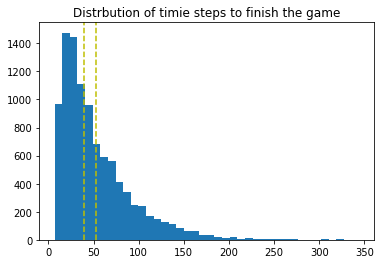

In [155]:
plt.hist(pathlengths,bins=40);
plt.title('Distrbution of timie steps to finish the game');
plt.axvline(np.mean(pathlengths), c='y',linestyle='--')
plt.axvline(np.median(pathlengths), c='y',linestyle='--')

In [157]:
np.mean(pathlengths)

52.7753

In [156]:
np.median(pathlengths)

40.0

# Q4: MRP

To model snakes and ladders as an MRP, we can set the "Reward" of every tile to be 1 and set $\gamma =1$. The value function will then represent how many more rolls are expected at each tile.

In [151]:
from rl.markov_process import FiniteMarkovRewardProcess

In [159]:
@dataclass(frozen=True)
class PositionState:
    position: int
from rl.markov_process import RewardTransition

In [166]:
class SnakeLadderMRP(FiniteMarkovRewardProcess[PositionState]):

    def __init__(
        self,
       
        dice_size: int,
        board_size: int,
        snake_ladders: Dict[int, int],):
        self.dice_size = dice_size
        self.board_size =board_size
        self.snake_ladders =snake_ladders
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> RewardTransition[PositionState]:
        d: Dict[PositionState, Optional[Categorical[Tuple[InventoryState, float]]]] = {
            PositionState(self.board_size) : None
        }
        for pos in range(self.board_size):
            reward = 1 
            state = PositionState(pos)
            state_probs_map: Mapping[Tuple[PositionState, float],int] = {}
            
            # roll dice 
            for dice_roll in range(1,self.dice_size+1):
                if dice_roll+pos >100:
                    j = 100-(dice_roll+pos-100)
                elif dice_roll+pos in self.snake_ladders.keys():
                    j = self.snake_ladders[dice_roll+pos]
                else:
                    j = dice_roll+pos
                
                state_probs_map[PositionState(j), reward] = 1/self.dice_size
            d[state] = Categorical(state_probs_map)
        return d

In [167]:
if __name__ == '__main__':

    sl_mrp = SnakeLadderMRP(
        board_size=100,
        dice_size=6,
       snake_ladders =snakes_and_ladders_map 
    )

    from rl.markov_process import FiniteMarkovProcess
    print("Transition Map")
    print("--------------")
    print(FiniteMarkovProcess(sl_mrp.transition_map))

    print("Transition Reward Map")
    print("---------------------")
    print(sl_mrp)

Transition Map
--------------
PositionState(position=100) is a Terminal State
From State PositionState(position=0):
  To State PositionState(position=1) with Probability 0.167
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
From State PositionState(position=1):
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
  To State PositionState(position=48) with Probability 0.167
From State PositionState(position=2):
  To State PositionState(position=39) with Probability 0.167
  To State PositionState

In [169]:
    print("Reward Function")
    print("---------------")
    sl_mrp.display_reward_function()
    print()

Reward Function
---------------
{PositionState(position=4): 1.0,
 PositionState(position=3): 1.0,
 PositionState(position=1): 1.0,
 PositionState(position=0): 1.0,
 PositionState(position=2): 1.0,
 PositionState(position=8): 1.0,
 PositionState(position=6): 1.0,
 PositionState(position=5): 1.0,
 PositionState(position=7): 1.0,
 PositionState(position=41): 1.0,
 PositionState(position=42): 1.0,
 PositionState(position=43): 1.0,
 PositionState(position=44): 1.0,
 PositionState(position=45): 1.0,
 PositionState(position=46): 1.0,
 PositionState(position=47): 1.0,
 PositionState(position=48): 1.0,
 PositionState(position=49): 1.0,
 PositionState(position=50): 1.0,
 PositionState(position=51): 1.0,
 PositionState(position=52): 1.0,
 PositionState(position=53): 1.0,
 PositionState(position=54): 1.0,
 PositionState(position=55): 1.0,
 PositionState(position=56): 1.0,
 PositionState(position=57): 1.0,
 PositionState(position=58): 1.0,
 PositionState(position=59): 1.0,
 PositionState(position=6

In [170]:
    print("Value Function")
    print("--------------")
    sl_mrp.display_value_function(gamma=1)
    print()

Value Function
--------------
{PositionState(position=4): 52.561,
 PositionState(position=3): 52.609,
 PositionState(position=1): 51.984,
 PositionState(position=0): 52.578,
 PositionState(position=2): 52.03,
 PositionState(position=8): 52.306,
 PositionState(position=6): 51.551,
 PositionState(position=5): 52.516,
 PositionState(position=7): 52.3,
 PositionState(position=41): 48.911,
 PositionState(position=42): 48.842,
 PositionState(position=43): 49.336,
 PositionState(position=44): 48.899,
 PositionState(position=45): 49.506,
 PositionState(position=46): 48.908,
 PositionState(position=47): 49.359,
 PositionState(position=48): 48.423,
 PositionState(position=49): 46.845,
 PositionState(position=50): 46.278,
 PositionState(position=51): 45.761,
 PositionState(position=52): 45.321,
 PositionState(position=53): 43.986,
 PositionState(position=54): 42.806,
 PositionState(position=55): 42.837,
 PositionState(position=56): 42.872,
 PositionState(position=57): 42.66,
 PositionState(positi

In [182]:
expected_return = round(sl_mrp.get_value_function_vec(gamma=1)[0], 5)
print("Expected number of dice rolls to finish the game: {}".format(expected_return))

Expected number of dice rolls to finish the game: 52.5777
